In [13]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

##Return Forecasting: Read Historical Daily Yen Futures Data

In [15]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
df = pd.read_csv("yen (1).csv", index_col="Date", infer_datetime_format=True, parse_dates=True)
df.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [16]:
# Trim the dataset to begin on January 1st, 1990
df = df.loc["1990-01-01":, :]
df.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


Return Forecasting: Initial Time-Series Plotting

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001ECB6938588>],
      dtype=object)

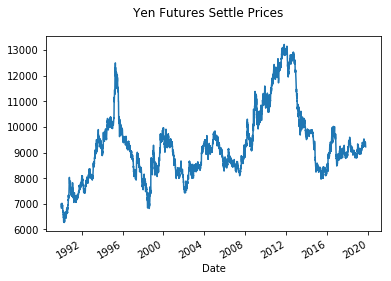

In [17]:
# Plot just the "Settle" column from the dataframe:
df.Settle.plot(subplots=True, title="Yen Futures Settle Prices")

#Decomposition Using a Hodrick-Prescott Filter

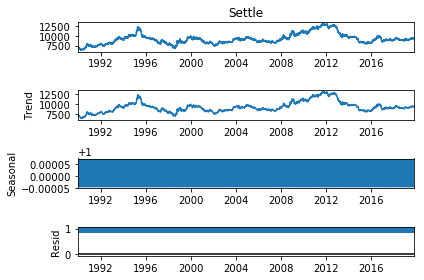

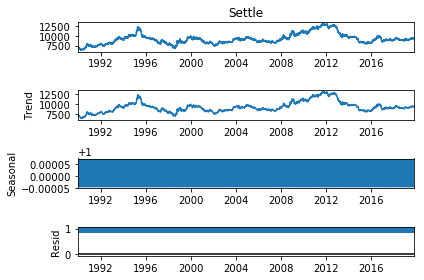

In [18]:
import statsmodels.api as sm

# Apply the Hodrick-Prescott Filter by decomposing the "Settle" price into two separate series:
decomposed = seasonal_decompose(df['Settle'], model='multiplicative', freq=3)
#decomposed = sm.tsa.seasonal_decompose(np.asarray(df['Settle']), freq=3)
decomposed.plot()

In [19]:
ts_noise, ts_trend = sm.tsa.filters.hpfilter(df['Settle'])

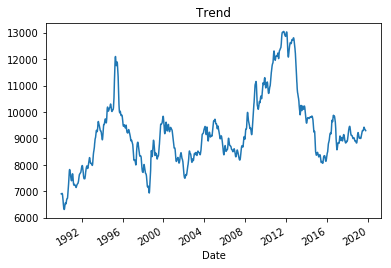

In [20]:
ts_trend.plot(title='Trend')

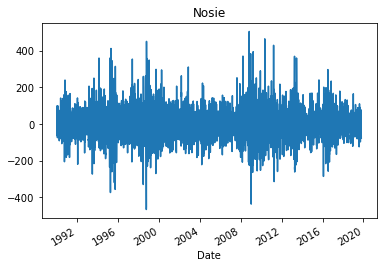

In [21]:
ts_noise.plot(title='Nosie')

In [22]:
ts_noise

Date
1990-01-02   -61.503967
1990-01-03   -21.799756
1990-01-04    98.942896
1990-01-05    40.776052
1990-01-08    49.689938
                ...    
2019-10-09    24.939247
2019-10-10    -5.868559
2019-10-11   -54.454594
2019-10-14   -36.423060
2019-10-15   -75.844123
Name: Settle_cycle, Length: 7515, dtype: float64

In [23]:
ts_trend


Date
1990-01-02    6908.503967
1990-01-03    6908.799756
1990-01-04    6909.057104
1990-01-05    6909.223948
1990-01-08    6909.310062
                 ...     
2019-10-09    9313.060753
2019-10-10    9309.368559
2019-10-11    9305.454594
2019-10-14    9301.423060
2019-10-15    9297.344123
Name: Settle_trend, Length: 7515, dtype: float64

In [24]:
futures_decomp = df[["Settle"]].copy()
futures_decomp["noise"] = ts_noise
futures_decomp["trend"] = ts_trend
futures_decomp.head()

,Settle,noise,trend
Date,,,
1990-01-02,6847.0,-61.503967,6908.503967
1990-01-03,6887.0,-21.799756,6908.799756
1990-01-04,7008.0,98.942896,6909.057104
1990-01-05,6950.0,40.776052,6909.223948
1990-01-08,6959.0,49.689938,6909.310062


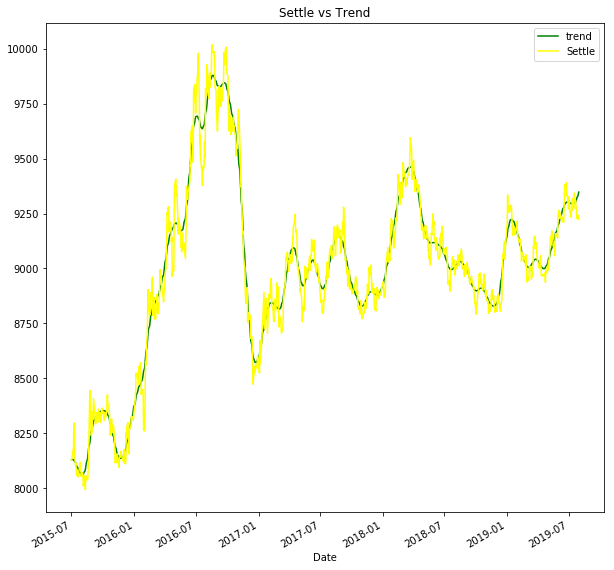

In [60]:
plt.figure(figsize=(10,10))
# Plot the Settle Price vs. the Trend for 2015 to the present
futures_decomp["trend"].loc['2015-07':'2019-07'].plot(x="Datetime", color='Green', title="Settle vs Trend")
futures_decomp["Settle"].loc['2015-07':'2019-07'].plot(x="Datetime", color='Yellow', title="Settle vs Trend")
plt.legend()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001ECB8A95408>],
      dtype=object)

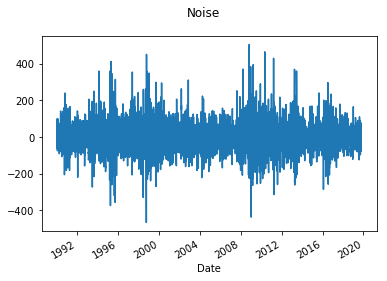

In [27]:
# Plot the Settle Noise
futures_decomp["noise"].plot(subplots=True, title="Noise")

Forecasting Returns using an ARMA Model

In [28]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [29]:
df = pd.read_csv("yen (1).csv", index_col="Date", infer_datetime_format=True, parse_dates=True)
df.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


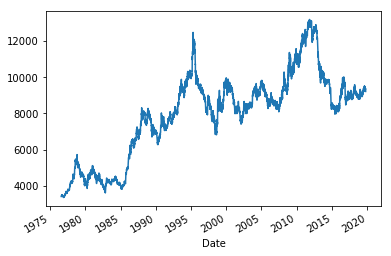

In [30]:
df.Settle.plot()

In [31]:
# Test to see if the data is stationary or non-stationary.
# Convert to stationary if needed.
from statsmodels.tsa.stattools import adfuller
adfuller(df.Settle)

(-1.9532611858094626,
 0.30743467595277424,
 0,
 10901,
 {'1%': -3.430950022064689,
  '5%': -2.8618051764738723,
  '10%': -2.5669111483059153},
 118845.03989471286)

In [32]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (df[["Settle"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Settle
Date,
2019-10-09,-0.410601
2019-10-10,-0.369458
2019-10-11,-0.564304
2019-10-14,0.151335
2019-10-15,-0.469509


In [33]:
df.columns

Index(['Open', 'High', 'Low', 'Last', 'Change', 'Settle', 'Volume',
       'Previous Day Open Interest'],
      dtype='object')

In [34]:
# Select only the returns
#Returns = df.loc[:, "returns"]

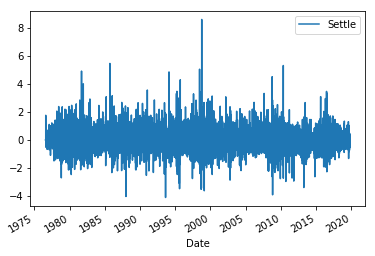

In [35]:
returns.plot()

In [36]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA

# Estimate and ARMA model using statsmodels (use order=(2, 1))
model = ARMA(returns.values, order=(2,1))
#model = ARMA(yen_futures.values.reshape(-1).tolist(), order=(2,1))

# Fit the model and assign it to a variable called results
results = model.fit()

In [37]:
# Output model summary results:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                10901
Model:                     ARMA(2, 1)   Log Likelihood              -11512.994
Method:                       css-mle   S.D. of innovations              0.696
Date:                Tue, 23 Feb 2021   AIC                          23035.987
Time:                        18:51:37   BIC                          23072.470
Sample:                             0   HQIC                         23048.284
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0116      0.007      1.748      0.080      -0.001       0.025
ar.L1.y       -0.6660      0.416     -1.600      0.110      -1.482       0.150
ar.L2.y       -0.0074      0.010     -0.770      0.441      -0.026       0.011
ma.L1.y        0.6611      0.416      1.588      0.112      -0.155       1.477
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.5273           +0.0000j            1.5273            0.5000
AR.2          -88.8116           +0.0000j           88.8116            0.5000
MA.1           -1.5126           +0.0000j            1.5126            0.5000
-----------------------------------------------------------------------------
"""

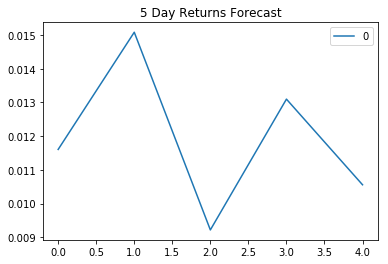

In [38]:
# Plot the 5 Day Returns Forecast
pd.DataFrame(results.forecast(steps=5)[0]).plot(title="5 Day Returns Forecast")

###Forecasting the Settle Price using an ARIMA Model

Using the raw Yen Settle Price, estimate an ARIMA model.
Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
Output the ARIMA summary table and take note of the p-values of the lags.
Based on the p-values, is the model a good fit (p < 0.05)?Construct a 5 day forecast for the Settle Price.
What does the model forecast will happen to the Japanese Yen in the near term?

In [39]:
import pandas as pd
import numpy as np
from matplotlib import pyplot
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [40]:
df = pd.read_csv("yen (1).csv", index_col="Date", infer_datetime_format=True, parse_dates=True)
df.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


###Autocorrelation and Partial Autocorrelation Analysis

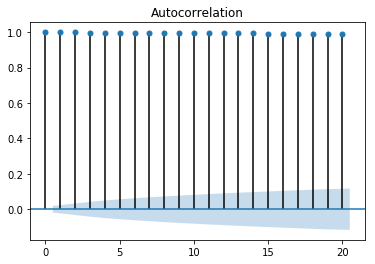

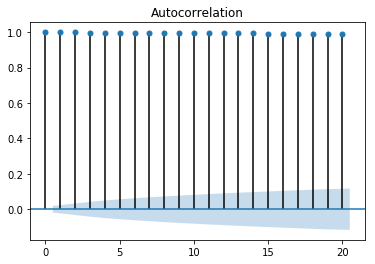

In [41]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df['High'], lags=20)

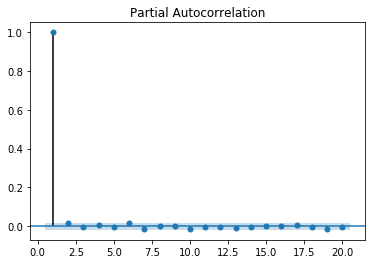

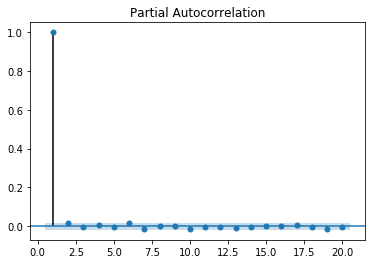

In [44]:
plot_pacf(df['Open'], zero=False, lags=20)#

In [45]:
from statsmodels.tsa.arima_model import ARIMA

In [46]:
# Estimate and ARIMA Model:
# Hint: ARIMA(df, order=(p, d, q))
model = ARIMA(df['Settle'], order=(5,1,1))

In [47]:
# Fit the model
results = model.fit()

In [48]:
# Output model summary results:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D.Settle   No. Observations:                10901
Model:                 ARIMA(5, 1, 1)   Log Likelihood              -59614.572
Method:                       css-mle   S.D. of innovations             57.385
Date:                Tue, 23 Feb 2021   AIC                         119245.144
Time:                        18:52:51   BIC                         119303.517
Sample:                             1   HQIC                        119264.818
                                                                              
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.5345      0.526      1.017      0.309      -0.496       1.565
ar.L1.D.Settle     0.2253      0.596      0.378      0.705      -0.942       1.393
ar.L2.D.Settle    -0.0026      0.012     -0.224      0.823      -0.025       0.020
ar.L3.D.Settle    -0.0061      0.010     -0.594      0.552      -0.026       0.014
ar.L4.D.Settle    -0.0133      0.011     -1.244      0.213      -0.034       0.008
ar.L5.D.Settle    -0.0025      0.014     -0.179      0.858      -0.029       0.024
ma.L1.D.Settle    -0.2357      0.596     -0.396      0.692      -1.403       0.932
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.9125           -1.4199j            2.3820           -0.1016
AR.2            1.9125           +1.4199j            2.3820            0.1016
AR.3           -1.7066           -3.0602j            3.5039           -0.3310
AR.4           -1.7066           +3.0602j            3.5039            0.3310
AR.5           -5.8527           -0.0000j            5.8527           -0.5000
MA.1            4.2426           +0.0000j            4.2426            0.0000
-----------------------------------------------------------------------------
"""

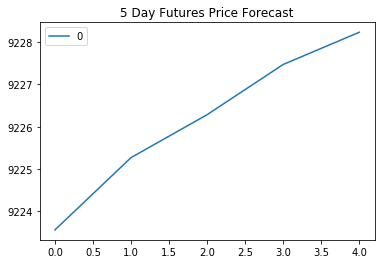

In [49]:
# Plot the 5 Day Price Forecast
pd.DataFrame(results.forecast(steps=5)[0]).plot(title="5 Day Futures Price Forecast")

###Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term volatility of Japanese Yen futures returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.

Using futures Settle Returns, estimate an GARCH model

GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
Output the GARCH summary table and take note of the p-values of the lags.
Based on the p-values, is the model a good fit (p < 0.05)?Plot the 5-day forecast of the volatility.

In [50]:
import arch 
from arch import arch_model
import pandas as pd
import numpy as np

In [51]:
df = pd.read_csv("yen (1).csv", index_col="Date", infer_datetime_format=True, parse_dates=True)
df.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [52]:
returns = df.Settle.pct_change() * 100
returns = returns.dropna()
returns.tail()

Date
2019-10-09   -0.410601
2019-10-10   -0.369458
2019-10-11   -0.564304
2019-10-14    0.151335
2019-10-15   -0.469509
Name: Settle, dtype: float64

In [53]:
# Estimate a GARCH model:
model = arch_model(returns, mean="Zero", vol="GARCH", p=2, q=1)

# Fit the model
result = model.fit(disp="off")

In [54]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                 Settle   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -10917.0
Distribution:                  Normal   AIC:                           21842.0
Method:            Maximum Likelihood   BIC:                           21871.2
                                        No. Observations:                10901
Date:                Tue, Feb 23 2021   Df Residuals:                    10901
Time:                        18:53:06   Df Model:                            0
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      4.6567e-03  3.287e-03      1.417      0.157 [-1.785e-03,1.110e-02]
alpha[1]       0.0404  1.388e-02      2.913  3.585e-03  [1.322e-02,6.764e-02]
alpha[2]   5.1841e-12  2.165e-02  2.395e-10      1.000 [-4.243e-02,4.243e-02]
beta[1]        0.9509  2.247e-02     42.328      0.000      [  0.907,  0.995]
=============================================================================

Covariance estimator: robust
"""

In [55]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2019-10-15'

In [56]:
# Create a 5 day forecast of volatility
forecast_horizon = 5
# Start the forecast using the last_day calculated above
forecasts = result.forecast(start='2019-10-15', horizon=forecast_horizon)
forecasts

In [57]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2019-10-15,7.461108,7.507407,7.553026,7.597982,7.642288


In [58]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

Date,2019-10-15
h.1,7.461108
h.2,7.507407
h.3,7.553026
h.4,7.597982
h.5,7.642288


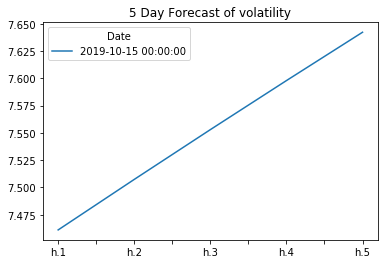

In [59]:
# Plot the final forecast
final.plot(title="5 Day Forecast of volatility")

###Conclusions

#Based on your time series analysis, would you buy the yen now?

Buy now

##Is the risk of the yen expected to increase or decrease?

Increase

##Based on the model evaluation, would you feel confident in using these models for trading?

Yes, We can use these models for trading